In [ ]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import re
import seaborn as sns

#### Membaca Data

In [ ]:
data = pd.read_csv(r'jawapos.csv',encoding='cp1252')
data.head(101)[['title', 'abstrak']]

,title,abstrak
0,APLIKASI CHATBOT BERBASIS WEB MENGGUNAKAN METO...,Chatbot adalah sebuah program komputer yang di...
1,Pelabelan Data Dengan Latent Dirichlet Allocat...,Media sosial telah cukup lama menjadi sumber u...
2,Penerapan Computer Vision Untuk Pendeteksian D...,Pembatasan kapasitas pengunjung pada suatu tem...
3,Klasifikasi Citra Game Batu Kertas Gunting Men...,"Permainan batu, gunting, dan kertas sangat pop..."
4,ANALISIS USAHA TERNAK AYAM BROILER DI PETERNAK...,Penelitian ini bertujuan untuk mengetahui besa...
...,...,...
96,FMEA dan Fuzzy FMEA dalam Penilaian Risiko Lea...,Salah satu masalah yang terjadi di industri ad...
97,PENDEKATAN ANN (ARTIFICIAL NEURAL NETWORK) UNT...,Pengambilan keputusan dalam estimasi biaya dal...
98,Simulasi Sloshing 2D pada Kontainer Segi Empat...,Konsep dinamika fluida sering diaplikasikan da...
99,Pemanfaatan Sistem Informasi Geografis Berbasi...,Perkembangan webgis yang saat ini belum ada pe...


#### Fungsi untuk Text Processing (Cleaning)

In [ ]:
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    """Fungsi ini membersihkan teks input dengan
     - menghapus link
     - menghapus karakter khusus
     - menghapus nomor
     - menghapus stopwords
     - mengubah dalam huruf kecil
     - menghapus spasi yang berlebihan
     Argumen:
         teks (str): teks untuk dibersihkan
         remove_stopwords (bool): True = hapus stopwords atau False = tidak
     """
    # Hapus links
    text = re.sub(r"http\S+", "", str(text))
    # Hapus nomor dan karakter khusus
    text = re.sub("[^A-Za-z]+", " ", str(text))
    # Hapus stopwords
    if remove_stopwords:
        # 1. Membuat Token
        tokens = nltk.word_tokenize(text)
        # 2. Mengecek token apabila terdapat stopwords maka dihapus
        stopwords_ind = stopwords.words("indonesian")
        stopwords_ind += ['com','rp','m','ol','nan','and'] #tambahan apabila stopwords tidak terdapat dalam corpus
        tokens = [w for w in tokens if not w.lower() in stopwords_ind]
        # 3. Mengabungkan token kembali
        text = " ".join(tokens)
    #mereturn text yang sudah dicleaning dengan huruf kecil
    text = text.lower().strip()
    return text

#### Fungsi untuk membuat WordCloud

In [ ]:
def wordCloudFunction(df,column,numWords):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words)) #menghitung frekuensi tiap kata
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True) #melakukan urutan berdasarkan frekuensi kata tertinggi
    word_string=str(popular_words) #mengubah tipe data menjadi string
    wordcloud = WordCloud(stopwords=stopwords.words("indonesian"),
                          background_color='white',
                          max_words=numWords,
                          width=1000,height=1000,
                         ).generate(word_string)

    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

#### Membuat data baru dari kolom title, content, dan summary yang sudah di preprocessing

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

data['cleanedtitle'] = data['title'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
data['cleanedabstrak'] = data['abstrak'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
data.head()[['title', 'abstrak','cleanedtitle','cleanedabstrak']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,title,abstrak,cleanedtitle,cleanedabstrak
0,APLIKASI CHATBOT BERBASIS WEB MENGGUNAKAN METO...,Chatbot adalah sebuah program komputer yang di...,aplikasi chatbot berbasis web metode dialogflow,chatbot program komputer dirancang menstimulas...
1,Pelabelan Data Dengan Latent Dirichlet Allocat...,Media sosial telah cukup lama menjadi sumber u...,pelabelan data latent dirichlet allocation k m...,media sosial sumber utama sentimen analisis tr...
2,Penerapan Computer Vision Untuk Pendeteksian D...,Pembatasan kapasitas pengunjung pada suatu tem...,penerapan computer vision pendeteksian penghit...,pembatasan kapasitas pengunjung situasi kondis...
3,Klasifikasi Citra Game Batu Kertas Gunting Men...,"Permainan batu, gunting, dan kertas sangat pop...",klasifikasi citra game batu kertas gunting con...,permainan batu gunting kertas populer dunia pe...
4,ANALISIS USAHA TERNAK AYAM BROILER DI PETERNAK...,Penelitian ini bertujuan untuk mengetahui besa...,analisis usaha ternak ayam broiler peternakan ...,penelitian bertujuan besarnya pendapatan usaha...


#### Visualisasi dalam bentuk Wordcloud dari kolom title, content, dan summary

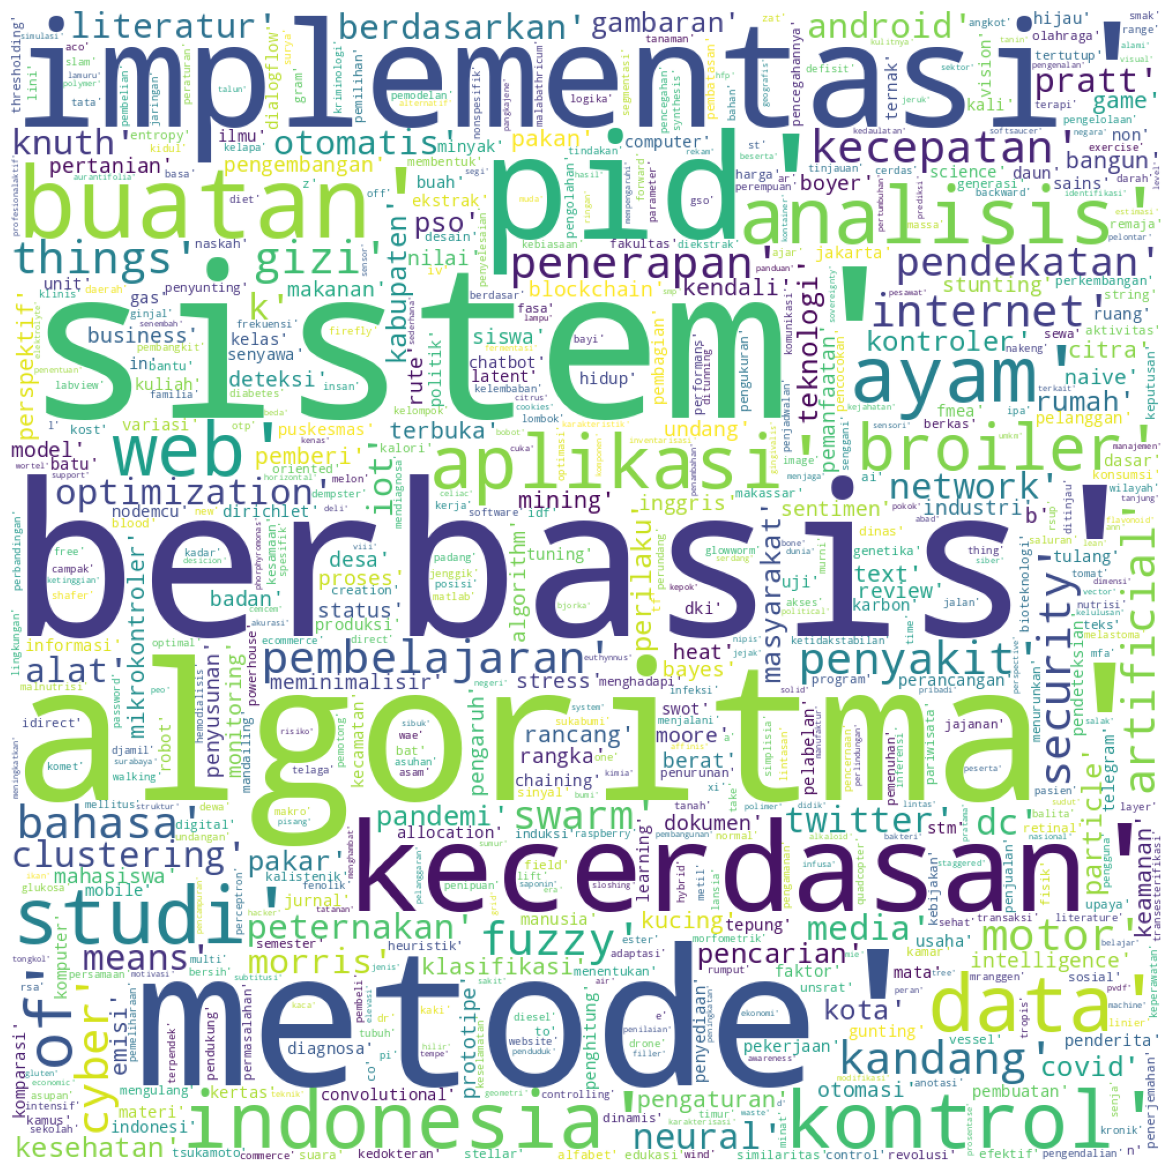

In [ ]:
plt.figure(figsize=(15,15))
wordCloudFunction(data,'cleanedtitle',10000000)

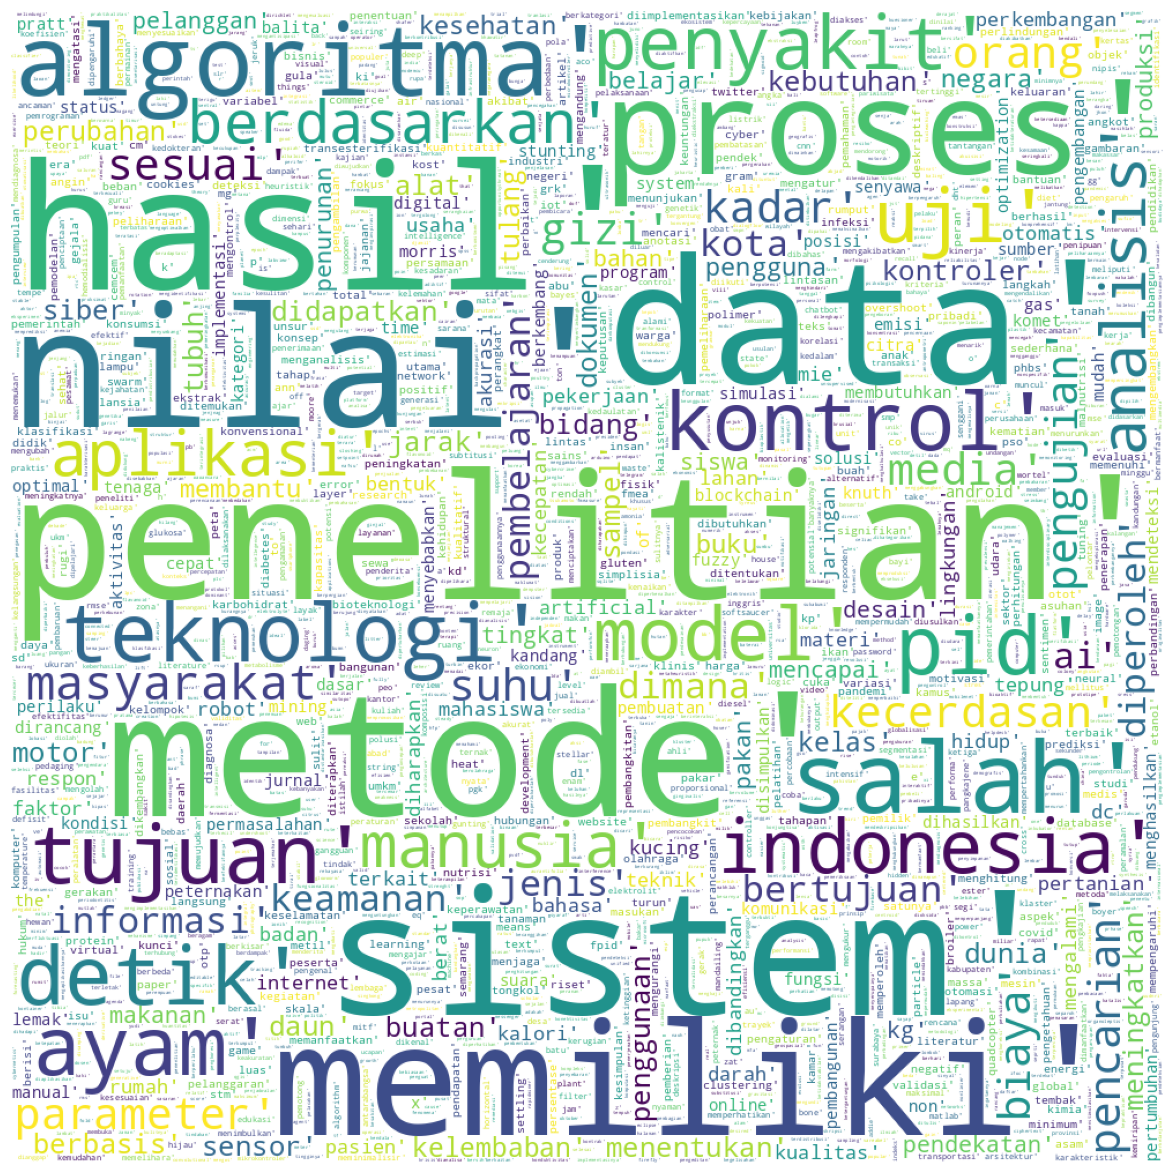

In [ ]:
plt.figure(figsize=(15,15))
wordCloudFunction(data,'cleanedabstrak',10000000)

#### Clustering menggunakan KMeans + TF-IDF


In [ ]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

# Membangun kamus (dictionary) dari data
texts = [document.split() for document in data['cleanedabstrak']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Menentukan jumlah topik yang akan dievaluasi
num_topics = range(2, 10)
coherence_scores = []

for n in num_topics:
    # Melatih model LDA pada data dengan jumlah topik n
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n)

    # Menghitung coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Menampilkan hasil coherence score untuk setiap jumlah topik
for n, score in zip(num_topics, coherence_scores):
    print("Number of topics: {}, Coherence Score: {}".format(n, score))

Number of topics: 2, Coherence Score: 0.33388616681149486
Number of topics: 3, Coherence Score: 0.34902464827304464
Number of topics: 4, Coherence Score: 0.3461326310955397
Number of topics: 5, Coherence Score: 0.37405384625245175
Number of topics: 6, Coherence Score: 0.34448414499718544
Number of topics: 7, Coherence Score: 0.35461250837250663
Number of topics: 8, Coherence Score: 0.3714842032825776
Number of topics: 9, Coherence Score: 0.3561533245149578


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

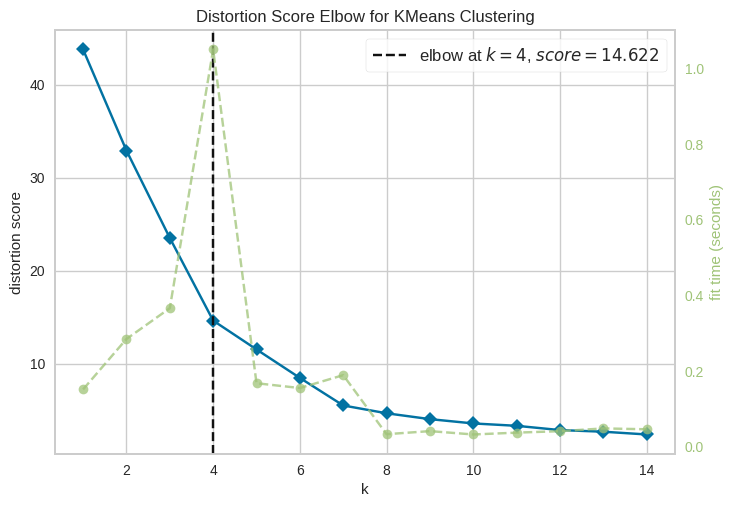

[3 0 3 3 2 3 2 3 0 0 1 2 0 1 1 0 1 1 3 0 1 0 0 3 1 0 2 3 0 0 2 2 1 2 2 2 3
 2 1 3 0 2 1 1 2 3 2 2 3 2 1 1 3 2 0 2 0 2 1 0 1 0 1 2 3 2 1 3 3 3 3 0 3 1
 0 3 3 1 3 0 2 1 1 2 1 2 1 1 0 1 2 0 0 0 0 3 2 0 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform menerapkan TF-IDF untuk membersihkan teks
tfidf = vectorizer.fit_transform(data['cleanedabstrak'])

# Inisialisasi LDA dengan 4 topik
lda = LatentDirichletAllocation(n_components=9, random_state=42)
# Fit model LDA
lda.fit(tfidf)
# Transformasikan data TF-IDF ke representasi topik LDA
lda_vecs = lda.transform(tfidf)

from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans(random_state=42)
kmeans = KElbowVisualizer(kmeans, k=(1,15))#KElbowVisualizer yang akan digunakan untuk menentukan jumlah kluster yang optimal. k menentukan rentang jumlah kluster yang akan diuji.
kmeans.fit(lda_vecs) #fitting data
kmeans.show() #mencetak data

kmeans = KMeans(n_clusters = 4, random_state=42) #inisialisasi kmeans dengan jumlah cluster 4 dan randomstate 42
kmeans.fit(lda_vecs) #fitting data

# simpan label cluster dalam sebuah variabel
clusters = kmeans.labels_

# inisialisasi PCA dengan 2 components
pca = PCA(n_components=2, random_state=42)
# lda_vecs ke pca
pca_vecs = pca.fit_transform(lda_vecs)

# simpan ke dalam x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

#membuat kolom baru untuk clusters, x0, dan x1
data['cluster'] = clusters
print(clusters)
data['x0'] = x0
data['x1'] = x1

In [ ]:
print(data.head(101)['cluster'])

0      3
1      0
2      3
3      3
4      2
      ..
96     2
97     0
98     1
99     0
100    1
Name: cluster, Length: 101, dtype: int32


In [ ]:
def get_top_keywords(n_terms):
    """Fungsi ini mengembalikan kata kunci untuk setiap centroid KMeans dan topik LDA"""
    df = pd.DataFrame(tfidf.todense()).groupby(clusters).mean() # mengelompokkan vektor TF-IDF berdasarkan cluster
    terms = vectorizer.get_feature_names_out()
    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # untuk setiap baris kerangka data, temukan n suku yang memiliki skor tf-idf tertinggi

    ## Menampilkan kata kunci untuk setiap topik LDA
    #feature_names = vectorizer.get_feature_names_out()
    #for i, topic_vec in enumerate(lda.components_):
        #top_keywords = [feature_names[i] for i in topic_vec.argsort()[:-n_terms - 1:-1]]
        #print('\nLDA Topic {}'.format(i))
        #print(','.join(top_keywords))

get_top_keywords(8)


Cluster 0
masyarakat,teknologi,sistem,aplikasi,algoritma,data,hasil,penelitian

Cluster 1
buatan,kecerdasan,menentukan,data,sistem,hasil,metode,penelitian

Cluster 2
meningkatkan,hasil,tubuh,metode,proses,tujuan,gizi,penelitian

Cluster 3
nilai,penelitian,manusia,kontrol,hasil,metode,pid,sistem


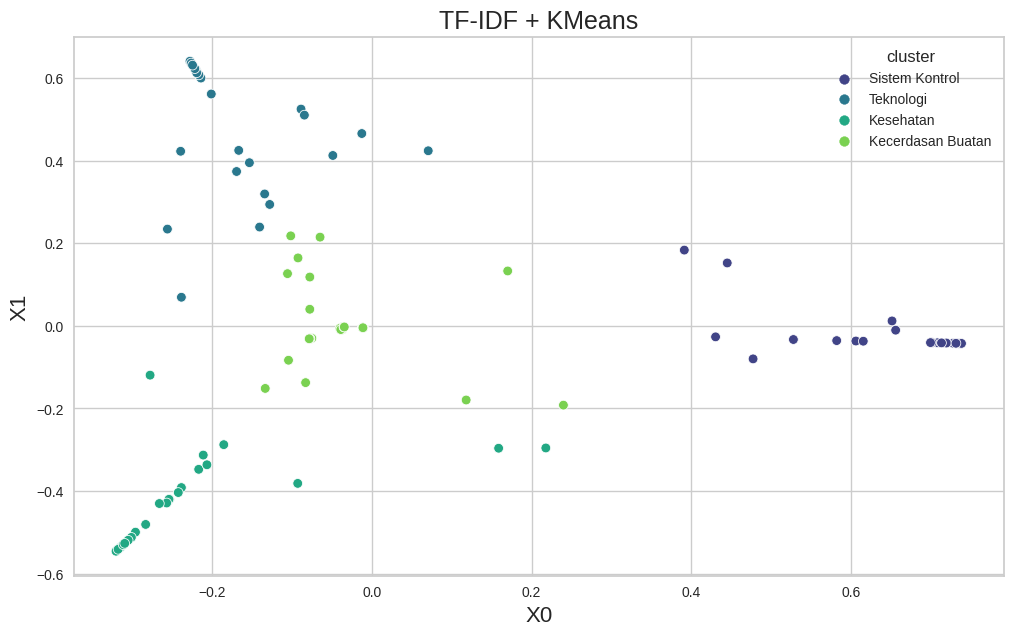

In [ ]:
cluster_map = {0: "Teknologi", 1: "Kecerdasan Buatan", 2: "Kesehatan",3:"Sistem Kontrol"} # Mapping dari cluster yang didapat dari fungsi get_top_keywords
data['cluster'] = data['cluster'].map(cluster_map)

#Image size
plt.figure(figsize=(12, 7))
#Judul
plt.title("TF-IDF + LDA + KMeans", fontdict={"fontsize": 18})
#AXIS X = X0, AXIS Y = X1
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
#plot
sns.scatterplot(data=data, x='x0', y='x1', hue='cluster', palette="viridis")

plt.show()

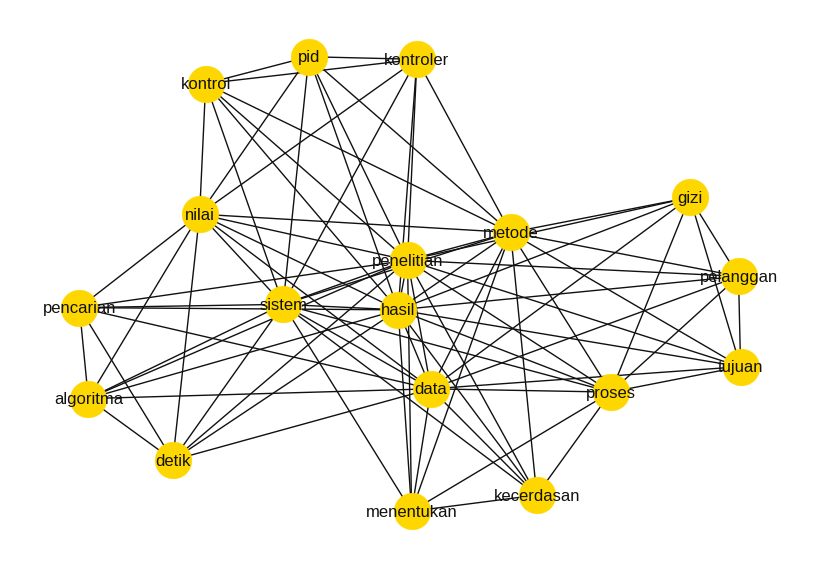

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Jumlah kata yang ingin ditampilkan untuk setiap cluster
topk = 8

# Menghitung frekuensi kemunculan kata-kata di setiap cluster
word_freq = {}
for i in range(len(data)):
    cluster = data['cluster'][i]
    text = data['cleanedabstrak'][i]
    for word in text.split():
        if cluster not in word_freq:
            word_freq[cluster] = {}
        if word not in word_freq[cluster]:
            word_freq[cluster][word] = 0
        word_freq[cluster][word] += 1

# Membuat graf
G = nx.Graph()

# Menambahkan edge antara kata-kata yang muncul dalam cluster yang sama
for cluster, word_dict in word_freq.items():
    # Mengambil hanya topk kata dengan frekuensi tertinggi
    topk_words = sorted(word_dict, key=word_dict.get, reverse=True)[:topk]
    for word1 in topk_words:
        for word2 in topk_words:
            if word1 != word2:
                G.add_edge(word1, word2)

# Menentukan posisi kata-kata dalam graf
pos = nx.spring_layout(G)

# Menggambar graf
nx.draw(G, pos, with_labels=True, node_color='gold', node_size=700)

# Menampilkan plot
plt.show()

In [ ]:
print(topk_words)

['penelitian', 'hasil', 'sistem', 'metode', 'data', 'kecerdasan', 'menentukan', 'proses']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


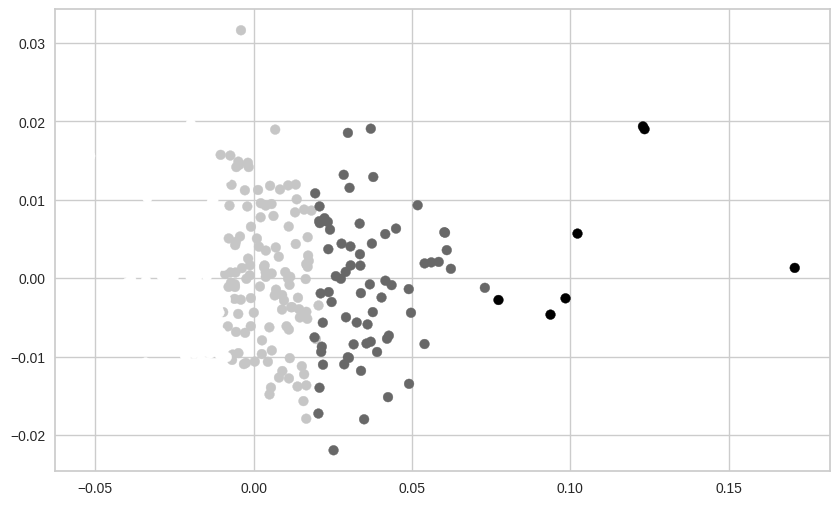


Cluster 0
industri,peningkatan,diabetes,kamus,iot,kelompok,quadcopter,learning

Cluster 1
perkembangan,global,aplikasi,sumber,konvensional,kecepatan,mudah,mendeteksi

Cluster 2
darah,robot,pelanggan,penggunaan,pid,hidup,media,pembelajaran

Cluster 3
data,sistem,hasil,metode,nilai,proses,memiliki,penelitian


In [ ]:
from gensim.models import Word2Vec

# Preprocess the text
preprocessed_text = data['cleanedabstrak'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

# Train Word2Vec model
sentences = [text.split() for text in preprocessed_text]
model = Word2Vec(sentences=sentences, window=2, min_count=7, workers=4, vector_size=100)

# Get word vectors
word_vectors = model.wv

# Perform dimensionality reduction
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors.vectors)

# Perform clustering
num_clusters = 4  # Set the number of clusters you want
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(word_vectors.vectors)

# Visualize the clusters
labels = kmeans.labels_
plt.figure(figsize=(10, 6))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], c=labels)
plt.show()

# Get cluster assignments for each word
word_clusters = {word: cluster for word, cluster in zip(word_vectors.index_to_key, labels)}


def get_top_keywords(n_terms):
    """Fungsi ini mengembalikan kata kunci untuk setiap centroid KMeans"""
    word_vectors = model.wv
    centroids = kmeans.cluster_centers_

    for i, centroid in enumerate(centroids):
        distances = np.linalg.norm(word_vectors.vectors - centroid, axis=1)
        top_indices = np.argsort(distances)[:n_terms]
        top_keywords = [word_vectors.index_to_key[idx] for idx in top_indices]

        print('\nCluster {}'.format(i))
        print(','.join(top_keywords))

get_top_keywords(8)